In [2]:
import pymc3 as pm
import numpy as np

import torch
from torch.distributions import * 

import matplotlib.pyplot as plt
import scipy.stats as scistats
from scipy.special import binom

from collections import defaultdict

from functools import reduce
import seaborn as sb

import pandas as pd

In [3]:
DATA_PATH = '../data'
import os
import h5py
from os.path import join, exists

#Data loading

In [25]:
# -*- coding: utf-8 -*-

import codecs

def get_basic_phoneme(phoneme):
	if phoneme[-1].isdigit():
		return phoneme[:-1]
	return phoneme

def get_phonemes(phonemes_code):
	return tuple([get_basic_phoneme(phoneme_code) for phoneme_code in phonemes_code.split(';')])

def get_pg_pair(pg_pair_code):
	phonemes_code, grapheme = pg_pair_code.split('>')
	return (get_phonemes(phonemes_code), grapheme)

def get_mapping(mapping_code):
	return tuple([get_pg_pair(pg_pair_code) for pg_pair_code in mapping_code.split('|')])

def read_phonix(input_file_name):
	phonix = []
	with codecs.open(input_file_name, encoding = 'utf-8') as input_file:
		for line in input_file:
			line = line.strip()
			if not line: continue
			word, mapping_code = line.split(' ')
			phonix.append((word, get_mapping(mapping_code)))
	return phonix

def pg_pair_to_str(pg_pair):
	phonemes, grapheme = pg_pair
	return '%s>%s' % (';'.join(phonemes), grapheme)

def mapping_to_str(mapping):
	return '|'.join(pg_pair_to_str(pg_pair) for pg_pair in mapping)
 
def read_freq_list(freq_file_name):
    wordfreqs = {}
    with open(freq_file_name) as input_file:
        for line in input_file:
            line = line.strip()
            word, freq = line.split(' ')
            freq = float(freq)
            wordfreqs[word] = freq
    return wordfreqs

def get_pg_freqs(wordfreqs, phonix):
    aggregator = defaultdict(float)
    for word, mapping in phonix:
        if word not in wordfreqs: continue
        wordfreq = wordfreqs[word]
        for pg in mapping:
            aggregator[pg_pair_to_str(pg)] += wordfreq
    return normalize(aggregator)

def word_pgs(phonix_dict, word):
    return [pg_pair_to_str(pg) for pg in phonix_dict[word]]
    
def observed_pgs(phonix_dict, observations):
    pgs = set()
    for word, obs in observations:
        pgs.update(word_pgs(phonix_dict, word))
    return pgs

In [5]:
def normalize(distr):
    denominator = sum(distr.values())
    return {key: float(value) / denominator for key, value in distr.items()}

In [6]:
phonix = read_phonix(join(DATA_PATH, 'phonix.txt'))
phonix_dict = dict(phonix)
wordfreqs = read_freq_list(join(DATA_PATH, 'word-freqs.txt'))

word_list = sorted(list(set(phonix_dict.keys()) & set(wordfreqs.keys() - {'null', 'nan'}))) 
#Above is because of strange behaviors with DF.

pg_freqs = get_pg_freqs(wordfreqs, phonix)

pgs = sorted(pg_freqs.keys(), key = lambda pg: pg_freqs[pg], reverse=True)
ps = np.array([pg_freqs[pg] for pg in pgs])

pg_idx = {pg : i for i, pg in enumerate(pgs)}

In [26]:
towre_phonix = read_phonix(join(DATA_PATH, 'towre_phonix.txt'))
towre_phonix_dict = dict(towre_phonix)
targets = [w for w, m in towre_phonix]

In [28]:
def gen_word2pg_counts(phonix_dict, word_list, pg_idx):
  #Some code taken from Ivan's.

  counts = []
  for word in word_list:

    #Identify idx of the pg pairs in word.
    the_word_pgs = word_pgs(phonix_dict, word)
    the_word_pgs_idx = np.array([pg_idx[pg] for pg in the_word_pgs])

    #Convert to one-hot like vector of counts
    this_counts = np.bincount(the_word_pgs_idx, minlength = len(pg_idx))
    counts.append(this_counts)

  return np.stack(counts)

word2pg_counts = torch.from_numpy(gen_word2pg_counts(towre_phonix_dict, targets, pg_idx)) #.cuda()

#Difficulty computation

In [29]:
#12/7: https://www.tensorflow.org/probability
#import tensorflow as tf
#import tensorflow_probability as tfp

In [30]:
def _probs_to_word_prob(probs_recall, word2pg_counts_arr):

    #Note that if the count for a given pg is zero, the result is 1,
    #  which doesn't affect the product as expected.
    raw_products = torch.pow(probs_recall, word2pg_counts_arr) #Check idx ordering?
    p_pg = torch.prod(raw_products, axis = 1) #Collapse pg, retain words.
  
    return p_pg
    
def simulate_child(word_list, prior_mu = np.log(500), prior_sigma = 3):

    lr = 0.3

    #12/7: https://stackoverflow.com/questions/34097281/convert-a-tensor-to-numpy-array-in-tensorflow
    log_n = torch.normal(mean = torch.tensor([float(prior_mu)]), std = torch.tensor([float(prior_sigma)]))
    n = int(np.ceil(np.exp(log_n.numpy())))

    n_pg_raw = torch.multinomial(torch.from_numpy(ps), n, replacement=True) #Fictional counts only.
    n_pg = torch.bincount(n_pg_raw, minlength = ps.shape[0])
    
    assert torch.sum(n_pg) == n, 'Allocation not correct.'
    
    #Simulate recalls.
    probs_recall = 1 - torch.exp(-lr * n_pg)
    words_probs = _probs_to_word_prob(probs_recall, word2pg_counts_arr = word2pg_counts)
    recalled = torch.bernoulli(words_probs)
    return recalled

In [45]:
def account_for_word_variants(word_list):
    counter = defaultdict(int)
    for word in word_list:
        if '(' in word: word = word[:word.find('(')]
        counter[word] += 1
    agg_word_list = list(sorted(counter.keys()))
    total_count = 0
    agg_intervals = []
    for word in mod_word_list:
        cnt = counter[word]
        agg_intervals.append((total_count, total_count + cnt))
        total_count += cnt
    return (agg_word_list, agg_intervals)
    

In [46]:
agg_word_list, agg_intervals = account_for_word_variants(targets)

In [50]:
def account_for_variants(recall, agg_intervals):
    agg = torch.zeros(len(agg_intervals), dtype = bool)
    for i, (start, end) in enumerate(agg_intervals):
        agg[i] = torch.any(recall[start : end].bool())
    return agg

In [51]:
def repeat_simulation(word_list, agg_intervals, trials):

  aggregate = torch.zeros((len(agg_intervals),))

  for trial_num in range(trials):
    if trial_num % 100 == 0:
      print(f'Trial: {trial_num}')
    this_child_recall = simulate_child(word_list)
    aggregated_recall = account_for_variants(this_child_recall, agg_intervals)
    aggregate += aggregated_recall

  difficulty = 1 - (aggregate / trials)
  return difficulty

In [52]:
difficulty = repeat_simulation(targets, agg_intervals, 5000) 

Trial: 0
Trial: 100
Trial: 200
Trial: 300
Trial: 400
Trial: 500
Trial: 600
Trial: 700
Trial: 800
Trial: 900
Trial: 1000
Trial: 1100
Trial: 1200
Trial: 1300
Trial: 1400
Trial: 1500
Trial: 1600
Trial: 1700
Trial: 1800
Trial: 1900
Trial: 2000
Trial: 2100
Trial: 2200
Trial: 2300
Trial: 2400
Trial: 2500
Trial: 2600
Trial: 2700
Trial: 2800
Trial: 2900
Trial: 3000
Trial: 3100
Trial: 3200
Trial: 3300
Trial: 3400
Trial: 3500
Trial: 3600
Trial: 3700
Trial: 3800
Trial: 3900
Trial: 4000
Trial: 4100
Trial: 4200
Trial: 4300
Trial: 4400
Trial: 4500
Trial: 4600
Trial: 4700
Trial: 4800
Trial: 4900


In [58]:
word_difficulty = {agg_word_list[i] : float(difficulty[i]) for i in range(len(agg_word_list))}

In [63]:
len(word_difficulty)

262

In [61]:
with open(join(DATA_PATH, "towre-difficulty-estimate.csv"), "w") as outfile:
    print("word, difficulty", file = outfile)
    for word in sorted(word_difficulty.keys()):
        print("%s,%f" % (word, word_difficulty[word]), file = outfile)

In [69]:
def getFormWords(form):
    words = []
    with open(join(DATA_PATH, "TOWRE", "Form_%s.csv" % form)) as infile:
        for line in infile:
            wrd = line[:line.find(",")]
            if wrd in word_difficulty:
                words.append(wrd)
    return words

In [70]:
getFormWords("A")

['ip',
 'ga',
 'ko',
 'ta',
 'om',
 'ig',
 'ni',
 'pim',
 'wum',
 'lat',
 'baf',
 'din',
 'nup',
 'fet',
 'bave',
 'pate',
 'herm',
 'dess',
 'chur',
 'knap',
 'tive',
 'barp',
 'stip',
 'plin',
 'frip',
 'poth',
 'vasp',
 'meest',
 'shlee',
 'guddy',
 'skree',
 'felly',
 'clirt',
 'sline',
 'dreef',
 'prain',
 'zint',
 'bloot',
 'trisk',
 'kelm',
 'strone',
 'lunaf',
 'cratty',
 'trober',
 'depate',
 'glant',
 'sploosh',
 'dreker',
 'ritlun',
 'hedfert',
 'bremick',
 'nifpate',
 'brinbert',
 'clabom',
 'drepnort',
 'shrattec',
 'plofent',
 'smucrit',
 'pelnador',
 'fornalask',
 'fermabalt',
 'crenidmoke',
 'emulbatate',
 'strotalanted',
 'prilingdorfent',
 'chunfendilt']

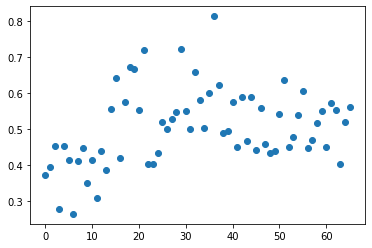

In [ ]:
for i, form in enumerate(["A", "B", "C", "D"]):
    form_words = getFormWords(form)
    plt.figure(i)
    plt.scatter(range(len(form_words)), [word_difficulty[word] for word in form_words])

#Tests

In [53]:
def test_gen_word2pg_counts():
  test_word_list = ['can', 'cactus']

  #Manually from pg_idx and phonix_dict:
  #'ʌ>a' -> 15
  #'k>c' -> 22
  #'n>n' -> 1
  #'æ>a' -> 4
  #'t>t' -> 0
  #'ʌ>u' -> 21
  #'s>s' -> 5

  actual = gen_word2pg_counts(test_word_list, pg_idx)
  list_where_one = [[22, 15, 1], [22, 4, 0, 21, 5]]

  expected = []
  for where_one in list_where_one:
    this_expected = np.zeros(len(pg_idx))
    this_expected[where_one] = 1
    expected.append(this_expected)

  expected[1][22] = 2 #Two k>c in "cactus".
  expected = np.stack(expected)

  assert np.all(actual == expected), 'word2pgcounts function check failed.'

In [54]:
def test_probs_to_word_prob():
  test_recall_probs = torch.from_numpy(np.array([2., 1., 3.]))
  test_counts = torch.from_numpy(np.array([
                          [0, 3, 2],
                          [1, 1, 0],
                          [3, 1, 2]
  ]))

  expected = torch.Tensor([9, 2, 72])
  actual = _probs_to_word_prob(test_recall_probs, test_counts)

  assert torch.all(expected == actual), 'probs to word prob test failed'

In [55]:
tests = [
         test_gen_word2pg_counts,
         test_probs_to_word_prob
]

for test in tests:
  test()

print('Tests passed.')

Tests passed.
